In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 59.0 MB/s eta 0:00:00


In [7]:
import numpy as np # linear algebra
import pandas as pd
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch

In [8]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")

In [9]:
behaviour_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/behaviors.tsv', sep="\t",names=["impressionId","userId","timestamp","click_history","impressions"])
print(behaviour_data.shape)
behaviour_data.head()

(156965, 5)


,impressionId,userId,timestamp,click_history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [10]:
print(behaviour_data.dtypes)

impressionId      int64
userId           object
timestamp        object
click_history    object
impressions      object
dtype: object


In [11]:

missing_values = behaviour_data.isnull().any()

print(missing_values)


impressionId     False
userId           False
timestamp        False
click_history     True
impressions      False
dtype: bool


In [12]:
behaviour_data['click_history'].fillna('', inplace=True)

In [13]:
uniqueIds = behaviour_data['userId'].unique()

ind2user = {idx +1: itemid for idx, itemid in enumerate(uniqueIds)}
user2ind = {itemid : idx for idx, itemid in ind2user.items()}
print(f"We have {len(user2ind)} unique users in the dataset")

behaviour_data['userIdx'] = behaviour_data['userId'].map(lambda x: user2ind.get(x,0))

We have 50000 unique users in the dataset


In [14]:
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news.tsv', sep="\t",names=["itemId","category","subcategory","title","abstract","url","title_entities","abstract_entities"])
news.head(2)

ind2item = {idx +1: itemid for idx, itemid in enumerate(news['itemId'].values)}
item2ind = {itemid : idx for idx, itemid in ind2item.items()}
print(news.shape)
news.head()

(51282, 8)


,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [15]:
missing_values = news.isnull().any()

print(missing_values)

itemId               False
category             False
subcategory          False
title                False
abstract              True
url                  False
title_entities        True
abstract_entities     True
dtype: bool


In [16]:
news.fillna('', inplace=True)

In [17]:
data=behaviour_data
def process_click_history(s):
    list_of_strings = str(s).split(" ")
    return [item2ind.get(l, 0) for l in list_of_strings]

data['click_history_idx'] = behaviour_data.click_history.map(lambda s:  process_click_history(s))
data.head()

,impressionId,userId,timestamp,click_history,impressions,userIdx,click_history_idx
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,1,"[6893, 10050, 15556, 21467, 26358, 4946, 14071..."
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,2,"[25816, 2334, 8524, 12087, 13463, 14202, 12733..."
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,3,"[5477, 4207, 11684, 7704, 8124, 23394, 22970, ..."
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,4,"[13827, 19085, 28506, 7024, 22910, 16667, 1559..."
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,5,"[23643, 4853, 27686, 31189]"


In [18]:
def process_impression(s):
    list_of_strings = s.split(" ")
    itemid_rel_tuple = [l.split("-") for l in list_of_strings]
    noclicks = []
    for entry in itemid_rel_tuple:
        if entry[1] =='0':
            noclicks.append(entry[0])
        if entry[1] =='1':
            click = entry[0]
    return noclicks, click

data['noclicks'], data['click'] = zip(*behaviour_data['impressions'].map(process_impression))

data['noclicks'] =data['noclicks'].map(lambda list_of_strings: [item2ind.get(l, 0) for l in list_of_strings])
data['noclick'] = data['noclicks'].map(lambda x : x[0])
data['click'] = data['click'].map(lambda x: item2ind.get(x,0))

In [ ]:
data.head()

,impressionId,userId,timestamp,click_history,impressions,userIdx,click_history_idx,noclicks,click,noclick
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,1,"[6893, 10050, 15556, 21467, 26358, 4946, 14071...",[50689],33900,50689
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,2,"[25816, 2334, 8524, 12087, 13463, 14202, 12733...","[37405, 41306, 34907, 35307, 44370, 37210, 439...",32187,37405
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,3,"[5477, 4207, 11684, 7704, 8124, 23394, 22970, ...","[39528, 33356, 38720, 43459, 794, 38061, 39830...",5767,39528
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,4,"[13827, 19085, 28506, 7024, 22910, 16667, 1559...","[50689, 50106, 50022]",50715,50689
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,5,"[23643, 4853, 27686, 31189]","[2006, 33272, 39220, 37210, 45683, 50113, 3663...",31475,2006


In [ ]:
data['epochhrs'] = pd.to_datetime(data['timestamp']).values.astype(np.int64)/(1e6)/1000/3600
data['epochhrs'] = data['epochhrs'].round()
data[['click','epochhrs']].groupby("click").min("epochhrs").reset_index()

,click,epochhrs
0,13,437047.0
1,28,437100.0
2,48,437079.0
3,75,437069.0
4,86,437150.0
...,...,...
6346,51263,437079.0
6347,51269,437063.0
6348,51271,437069.0
6349,51275,437063.0


In [ ]:
data.head()

,impressionId,userId,timestamp,click_history,impressions,userIdx,click_history_idx,noclicks,click,noclick,epochhrs
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,1,"[6893, 10050, 15556, 21467, 26358, 4946, 14071...",[50689],33900,50689,437073.0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,2,"[25816, 2334, 8524, 12087, 13463, 14202, 12733...","[37405, 41306, 34907, 35307, 44370, 37210, 439...",32187,37405,437106.0
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,3,"[5477, 4207, 11684, 7704, 8124, 23394, 22970, ...","[39528, 33356, 38720, 43459, 794, 38061, 39830...",5767,39528,437143.0
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,4,"[13827, 19085, 28506, 7024, 22910, 16667, 1559...","[50689, 50106, 50022]",50715,50689,437069.0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,5,"[23643, 4853, 27686, 31189]","[2006, 33272, 39220, 37210, 45683, 50113, 3663...",31475,2006,437104.0


In [ ]:
dataR =data[['epochhrs','userIdx','click_history_idx','noclick','click']]
dataR.head()

,epochhrs,userIdx,click_history_idx,noclick,click
0,437073.0,1,"[6893, 10050, 15556, 21467, 26358, 4946, 14071...",50689,33900
1,437106.0,2,"[25816, 2334, 8524, 12087, 13463, 14202, 12733...",37405,32187
2,437143.0,3,"[5477, 4207, 11684, 7704, 8124, 23394, 22970, ...",39528,5767
3,437069.0,4,"[13827, 19085, 28506, 7024, 22910, 16667, 1559...",50689,50715
4,437104.0,5,"[23643, 4853, 27686, 31189]",2006,31475


In [ ]:
dataR.head()

,epochhrs,userIdx,click_history_idx,noclick,click
0,437073.0,1,"[6893, 10050, 15556, 21467, 26358, 4946, 14071...",50689,33900
1,437106.0,2,"[25816, 2334, 8524, 12087, 13463, 14202, 12733...",37405,32187
2,437143.0,3,"[5477, 4207, 11684, 7704, 8124, 23394, 22970, ...",39528,5767
3,437069.0,4,"[13827, 19085, 28506, 7024, 22910, 16667, 1559...",50689,50715
4,437104.0,5,"[23643, 4853, 27686, 31189]",2006,31475


In [ ]:
temp = data[['epochhrs','userIdx','noclick','click']]

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
X_temp=X_temp = temp.drop('click', axis=1)
y_temp=temp['click']

selector = SelectKBest(score_func=f_classif, k=2)  # Select the top 2 features using ANOVA F-value
X_temp_selected = selector.fit_transform(X_temp, y_temp)

selected_indices = selector.get_support(indices=True)

selected_features_content_based = X_temp.columns[selected_indices]

print("Selected Features for Content-Based Filtering:")
print(selected_features_content_based)


Selected Features for Content-Based Filtering:
Index(['epochhrs', 'noclick'], dtype='object')


In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [21]:
newsdata = news

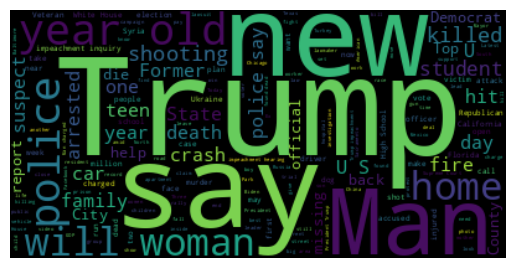

In [24]:
#WORDCLOUD FOR NEWS
text=' '
for i in newsdata[newsdata['category']=='news']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

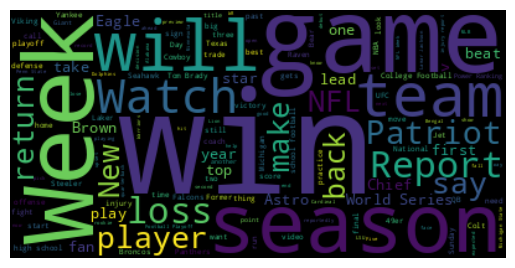

In [25]:
#WORDCLOUD FOR SPORTS NEWS
text=' '
for i in newsdata[newsdata['category']=='sports']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [ ]:
print(news.dtypes)

itemId               object
category             object
subcategory          object
title                object
abstract             object
url                  object
title_entities       object
abstract_entities    object
dtype: object


In [ ]:
X_news = news[['category', 'subcategory', 'title', 'abstract', 'title_entities', 'abstract_entities']]
y_user = behaviour_data['click_history']

BY VARSH

In [ ]:
print('the number of articles before processing :',len(news))
news.drop_duplicates(subset=['title'],inplace=True)
print('The number of articles after processing :',len(news))

the number of articles before processing : 51282
The number of articles after processing : 50434


In [ ]:
df2=news.copy()

In [ ]:
df2

,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[]
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[]
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[]


In [ ]:
print(news['title'])

0        The Brands Queen Elizabeth, Prince Charles, an...
1                            50 Worst Habits For Belly Fat
2        The Cost of Trump's Aid Freeze in the Trenches...
3        I Was An NBA Wife. Here's How It Affected My M...
4        How to Get Rid of Skin Tags, According to a De...
                               ...                        
51277    Adapting, Learning And Soul Searching: Reflect...
51278    Family says 13-year-old Broadway star died fro...
51279    St. Dominic soccer player tries to kick cancer...
51280                         How the Sounders won MLS Cup
51281                    Best Sports Car Deals for October
Name: title, Length: 50434, dtype: object


## *BAGGING  METHOD  *

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances

headline_vectorizer = TfidfVectorizer()
headline_features = headline_vectorizer.fit_transform(news['title'].values)

def Euclidean_Distance_based_model(row_index, num_similar_items):
    cate = news['category'][row_index]
    name = news['title'][row_index]
    cate_data = news[news['category'] == cate]

    row_index2 = cate_data[cate_data['title'] == name].index
    couple_dist = pairwise_distances(headline_features, headline_features[row_index2])

    num_similar_items = min(num_similar_items, len(cate_data) - 1)

    indices = np.argsort(couple_dist.ravel())[:num_similar_items]

    indices = [i for i in indices if i < len(cate_data)]

    df = pd.DataFrame({
        'headline': cate_data['title'].values[indices],
        'Category': cate_data['category'].values[indices],
        'Abstract': cate_data['abstract'].values[indices],
        'Euclidean similarity with the queried article': couple_dist[indices].ravel()
    })
    print("=" * 30, "News Article Name", "=" * 30)
    print('News Headline : ', name)
    print("\n", "=" * 30, "Recommended News : ", "=" * 30)
    return df.iloc[1:, :]

name = input('News Title For Recommendation:')
ind = news[news['title'] == name].index[0]
dd = Euclidean_Distance_based_model(ind, min(10, len(news)))  # Adjust the number of similar items as needed
dd.head(10)


News Title For Recommendation:50 Worst Habits For Belly Fat
============================== News Article Name ==============================
News Headline :  50 Worst Habits For Belly Fat

 ============================== Recommended News :  ==============================


,headline,Category,Abstract,Euclidean similarity with the queried article
1,Why Are Uterine Cancer Rates Rising So Drastic...,health,A CDC report found that black women are more l...,1.166388
2,This Trainer Used a Weeklong Jump Rope Workout...,health,Brandon Epstein worked out for just 30 minutes...,1.174239


## **TF-IDF**

In [ ]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)

In [ ]:
pip install tabulate

# **Content recommendation**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['click_history'])

from tabulate import tabulate

def TFIDF_based_model(row_index, num_similar_items):
    user_data = data.iloc[row_index]
    user_click_history = user_data['click_history']

    couple_dist = pairwise_distances(tfidf_matrix, tfidf_matrix[user_data.name])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]

    recommended_articles = data.iloc[indices]

    print("=" * 30, "User Click History", "=" * 30)
    print('User Click History : ', user_click_history)
    print("\n", "=" * 26, "Recommended Articles Using TF-IDF: ", "=" * 26)

    table_data = recommended_articles[['impressionId', 'userId', 'timestamp', 'click_history', 'impressions']]
    print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

user_idx = int(input("Enter the user id : "))
recommended_articles = TFIDF_based_model(user_idx, 10)


Enter the user id : 33
============================== User Click History ==============================
User Click History :  N49519 N2691 N26567 N54359 N20830 N995 N36053 N49103 N8569 N13893 N64541 N47737 N23196 N60604 N57140 N54571 N6778 N39838

 ========================== Recommended Articles Using TF-IDF:  ==========================
╒════════╤════════════════╤══════════╤════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [ ]:
from tabulate import tabulate

def TFIDF_based_model(row_index, num_similar_items):
    article_data = news.iloc[row_index]
    article_title = article_data['title']
    category_data = news[news['category'] == article_data['category']]

    row_index2 = category_data[category_data['title'] == article_title].index
    headline_features = tfidf_vectorizer.transform(category_data['title'].values)
    couple_dist = pairwise_distances(headline_features, headline_features[row_index2])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]

    recommended_articles = category_data.iloc[indices]

    print("=" * 30, "Article Title", "=" * 30)
    print('Article Title : ', article_data['title'])
    print("\n", "=" * 26, "Recommended Articles Using TF-IDF: ", "=" * 26)

    table_data = recommended_articles[['title', 'category', 'abstract', 'url']]
    print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

article_idx = int(input("Enter the article id : "))
TFIDF_based_model(article_idx, 10)


Enter the article id : 34
============================== Article Title ==============================
Article Title :  20 Must-Try Gravy Recipes for Your Thanksgiving Feast

 ========================== Recommended Articles Using TF-IDF:  ==========================
╒═══════╤═════════════════════════════════════════════════════════════════════════╤══════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════╕
│       │ title                                                                   │ category     │ abstract                                                                                                                                                                                    │ url                                           │
╞═══════╪════════════════════════════════════════════════════

In [ ]:
print(data.shape)

(156965, 11)


In [ ]:
print(news.shape)

(50434, 8)


# **Category Recommendation System**

In [ ]:
X=news['title'].values
y=news['category'].values

**TF-IDF AND DECISION TREE**

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

tfidf_vectorizer = TfidfVectorizer(min_df=4)

svd = TruncatedSVD(n_components=400, n_iter=8, random_state=42)

dt_classifier = DecisionTreeClassifier()

pipeline = make_pipeline(tfidf_vectorizer, svd, dt_classifier)

pipeline.fit(X_train, y_train)

def print_report(pipe):
    y_pred = pipe.predict(X_test)
    labels = np.unique(np.concatenate((y_train, y_test)))
    report = metrics.classification_report(y_test, y_pred, target_names=labels)
    print(report)
    print("Accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))


print_report(pipeline)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        autos       0.12      0.12      0.12       510
entertainment       0.07      0.07      0.07       174
      finance       0.12      0.12      0.12       933
 foodanddrink       0.22      0.22      0.22       769
       health       0.11      0.12      0.12       541
         kids       0.00      0.00      0.00         8
    lifestyle       0.12      0.13      0.12       727
   middleeast       0.00      0.00      0.00         0
       movies       0.08      0.08      0.08       179
        music       0.07      0.07      0.07       240
         news       0.49      0.47      0.48      4732
 northamerica       0.00      0.00      0.00         0
       sports       0.57      0.56      0.56      4243
       travel       0.08      0.08      0.08       668
           tv       0.03      0.04      0.03       239
        video       0.07      0.08      0.08       571
      weather       0.23      0.22      0.22       597

     acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Pipeline using TruncatedSVD and XGBClassifier**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

tfidf_vectorizer = TfidfVectorizer(min_df=0)

svd = TruncatedSVD(n_components=10, n_iter=1, random_state=42)

xgb_classifier = XGBClassifier()

pipeline = make_pipeline(tfidf_vectorizer, svd, xgb_classifier)

pipeline.fit(X_train, y_train_encoded)

y_pred_encoded = pipeline.predict(X_test)
report = classification_report(y_test_encoded, y_pred_encoded)
print(report)


              precision    recall  f1-score   support

           0       0.27      0.05      0.08       510
           1       0.27      0.03      0.06       174
           2       0.17      0.04      0.06       933
           3       0.27      0.20      0.23       769
           4       0.17      0.08      0.11       541
           5       0.00      0.00      0.00         8
           6       0.21      0.09      0.12       727
           8       0.50      0.05      0.09       179
           9       0.38      0.01      0.02       240
          10       0.48      0.73      0.58      4732
          12       0.50      0.72      0.59      4243
          13       0.19      0.04      0.07       668
          14       0.18      0.01      0.02       239
          15       0.24      0.02      0.04       571
          16       0.40      0.14      0.21       597

    accuracy                           0.46     15131
   macro avg       0.28      0.15      0.15     15131
weighted avg       0.39   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Pipeline using TruncatedSVD and LGBMClassifier**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

tfidf_vectorizer = TfidfVectorizer(min_df=0)

svd = TruncatedSVD(n_components=100, n_iter=1, random_state=42)

lgbm_classifier = LGBMClassifier()

pipeline = make_pipeline(tfidf_vectorizer, svd, lgbm_classifier)

pipeline.fit(X_train, y_train_encoded)


y_pred_encoded = pipeline.predict(X_test)
report = classification_report(y_test_encoded, y_pred_encoded)
print(report)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 35303, number of used features: 100
[LightGBM] [Info] Start training from score -3.451533
[LightGBM] [Info] Start training from score -4.467836
[LightGBM] [Info] Start training from score -2.802228
[LightGBM] [Info] Start training from score -2.999222
[LightGBM] [Info] Start training from score -3.278037
[LightGBM] [Info] Start training from score -8.392282
[LightGBM] [Info] Start training from score -3.015847
[LightGBM] [Info] Start training from score -9.778576
[LightGBM] [Info] Start training from score -4.421990
[LightGBM] [Info] Start training from score -4.212142
[LightGBM] [Info] Start training from score -1.183774
[LightGBM] [Info] Start training from score -10.471723
[LightGBM] [Info] Start training from score -1.273051
[Light

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**LGBMClassifier worked the best amongst all 3 it gave 50% accuracy**

PATE ALGORITHM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from syft.frameworks.torch.dp import pate

In [ ]:
X=news['title'].values
y=news['category'].values

In [ ]:
X_public, X_private, y_public, y_private = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

X_teachers, X_students, y_teachers, y_students = train_test_split(X_private, y_private, test_size=0.2, random_state=42)

num_teachers = 5
teacher_models = []

for i in range(num_teachers):

    model = RandomForestClassifier()
    model.fit(X_teachers[i], y_teachers[i])
    teacher_models.append(model)

teacher_preds_public = []

for model in teacher_models:
    preds = model.predict(X_public)
    teacher_preds_public.append(preds)

epsilon = 0.1
noisy_teacher_preds_public = pate.perform_analysis(teacher_preds_public, epsilon=epsilon, delta=1e-5)

student_model = RandomForestClassifier()
student_model.fit(noisy_teacher_preds_public, y_public)

student_preds_private = student_model.predict(X_private)

accuracy_private = np.sum(student_preds_private == y_private) / len(y_private)
print(f"Student model accuracy on private dataset: {accuracy_private}")
